In [1]:
import pandas as pd
import plotly.express as px
import matplotlib.pyplot as plt
import numpy as np
import plotly.graph_objects as go
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import IsolationForest
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, precision_recall_curve

In [2]:
data = pd.read_csv("transaction_anomalies_dataset.csv")
data.head()

Transaction_ID  Transaction_Amount  Transaction_Volume  \
0            TX0         1024.835708                   3   
1            TX1         1013.952065                   4   
2            TX2          970.956093                   1   
3            TX3         1040.822254                   2   
4            TX4          998.777241                   1   

   Average_Transaction_Amount  Frequency_of_Transactions  \
0                  997.234714                         12   
1                 1020.210306                          7   
2                  989.496604                          5   
3                  969.522480                         16   
4                 1007.111026                          7   

   Time_Since_Last_Transaction Day_of_Week Time_of_Day  Age  Gender   Income  \
0                           29      Friday        6:00   36    Male  1436074   
1                           22      Friday        1:00   41  Female   627069   
2                           12     Tuesday       21:00   61    Male   786232   
3                           28      Sunday       14:00   61    Male   619030   
4                            7      Friday        8:00   56  Female   649457   

  Account_Type  
0      Savings  
1      Savings  
2      Savings  
3      Savings  
4      Savings

In [3]:
data.isnull().sum()

Transaction_ID                 0
Transaction_Amount             0
Transaction_Volume             0
Average_Transaction_Amount     0
Frequency_of_Transactions      0
Time_Since_Last_Transaction    0
Day_of_Week                    0
Time_of_Day                    0
Age                            0
Gender                         0
Income                         0
Account_Type                   0
dtype: int64

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 12 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Transaction_ID               1000 non-null   object 
 1   Transaction_Amount           1000 non-null   float64
 2   Transaction_Volume           1000 non-null   int64  
 3   Average_Transaction_Amount   1000 non-null   float64
 4   Frequency_of_Transactions    1000 non-null   int64  
 5   Time_Since_Last_Transaction  1000 non-null   int64  
 6   Day_of_Week                  1000 non-null   object 
 7   Time_of_Day                  1000 non-null   object 
 8   Age                          1000 non-null   int64  
 9   Gender                       1000 non-null   object 
 10  Income                       1000 non-null   int64  
 11  Account_Type                 1000 non-null   object 
dtypes: float64(2), int64(5), object(5)
memory usage: 93.9+ KB


In [5]:
data.describe()

Transaction_Amount  Transaction_Volume  Average_Transaction_Amount  \
count         1000.000000         1000.000000                 1000.000000   
mean          1038.122511            2.498000                 1000.682506   
std            283.580055            1.115006                   20.632334   
min            849.024392            1.000000                  939.081423   
25%            966.028796            1.000000                  986.800556   
50%           1002.118678            3.000000                 1000.501903   
75%           1033.143657            3.000000                 1015.155595   
max           3227.459108            4.000000                 1073.154036   

       Frequency_of_Transactions  Time_Since_Last_Transaction          Age  \
count                1000.000000                  1000.000000  1000.000000   
mean                   12.078000                    15.341000    40.641000   
std                     4.245225                     8.361258    13.819953   
min                     5.000000                     1.000000    18.000000   
25%                     8.000000                     8.000000    29.000000   
50%                    12.000000                    16.000000    41.000000   
75%                    16.000000                    22.000000    53.000000   
max                    19.000000                    29.000000    64.000000   

             Income  
count  1.000000e+03  
mean   8.948238e+05  
std    3.453562e+05  
min    3.001590e+05  
25%    5.917308e+05  
50%    8.876645e+05  
75%    1.178102e+06  
max    1.499670e+06

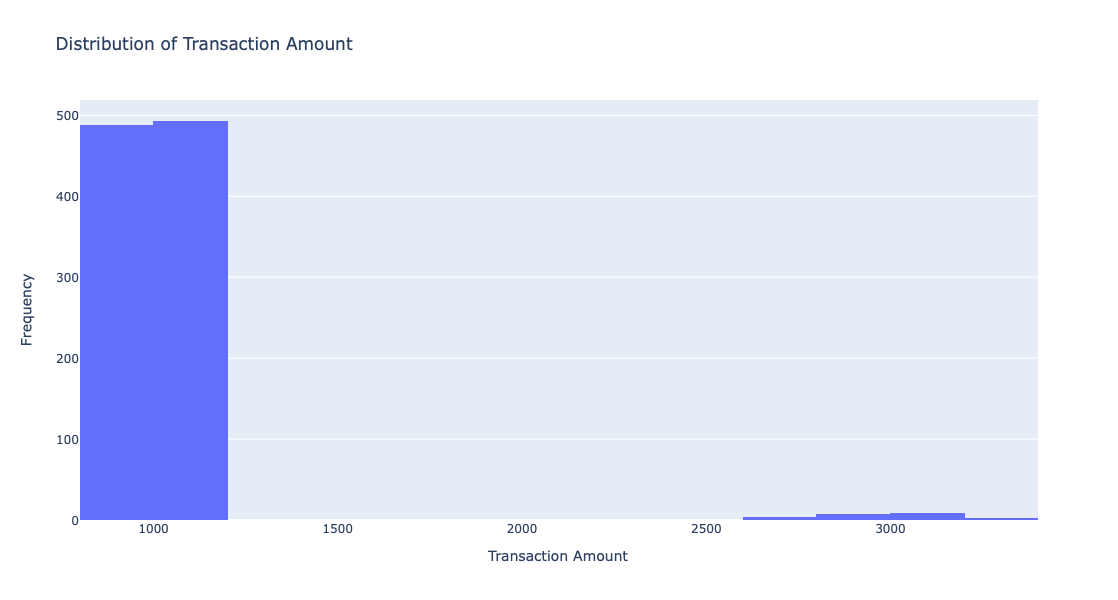

In [6]:
# Distribution of Transaction (Histogram)
dist_transaction = px.histogram(data, x = 'Transaction_Amount', nbins = 20, title = 'Distribution of Transaction Amount')
dist_transaction.update_layout(width = 1000, height = 600, xaxis_title = 'Transaction Amount', yaxis_title = 'Frequency')
dist_transaction.show()

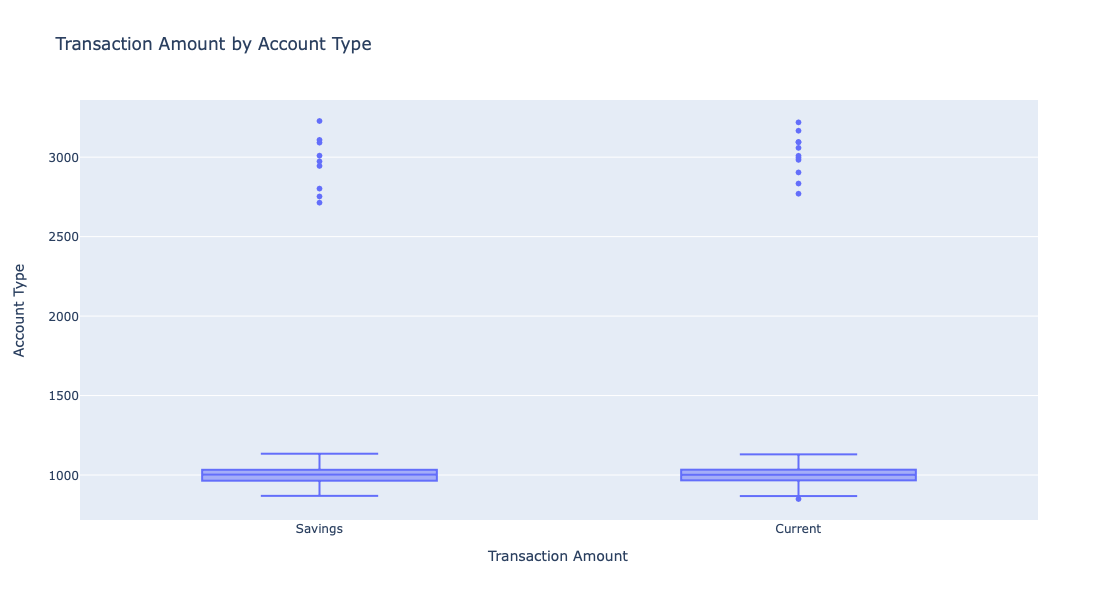

In [7]:
# Transaction Amount by Account type (Box plot)
transaction_acc_type = px.box(data, x = 'Account_Type', y = 'Transaction_Amount', title = 'Transaction Amount by Account Type')
transaction_acc_type.update_layout(width = 1000, height = 600, xaxis_title = 'Transaction Amount', yaxis_title = 'Account Type')
transaction_acc_type.show()

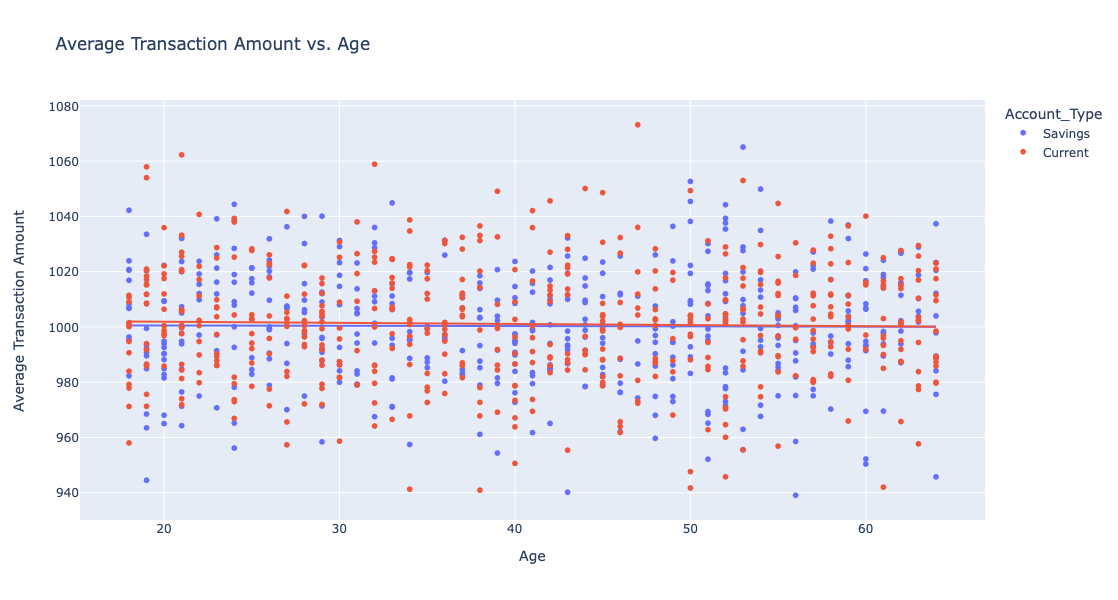

In [8]:
# Average transaction amount vs. age (Scatter plot)
avg_amount_age = px.scatter(data, x = 'Age', y = 'Average_Transaction_Amount', color = 'Account_Type',
                            title = 'Average Transaction Amount vs. Age', trendline = 'ols')
avg_amount_age.update_layout(width = 1000, height = 600, yaxis_title = 'Average Transaction Amount', xaxis_title = 'Age')
avg_amount_age.show()

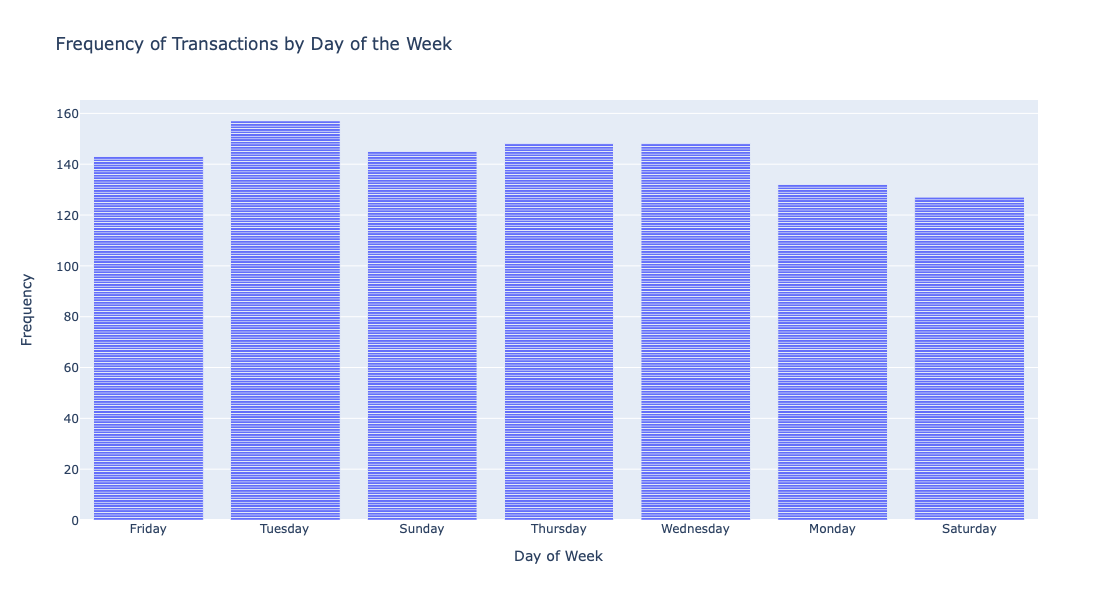

In [9]:
# Count of Transaction by Day of the Week (Bar chart)
day_of_week = px.bar(data, x = 'Day_of_Week', title = 'Frequency of Transactions by Day of the Week')
day_of_week.update_layout(width = 1000, height = 600, yaxis_title = 'Frequency', xaxis_title = 'Day of Week')
day_of_week.show()

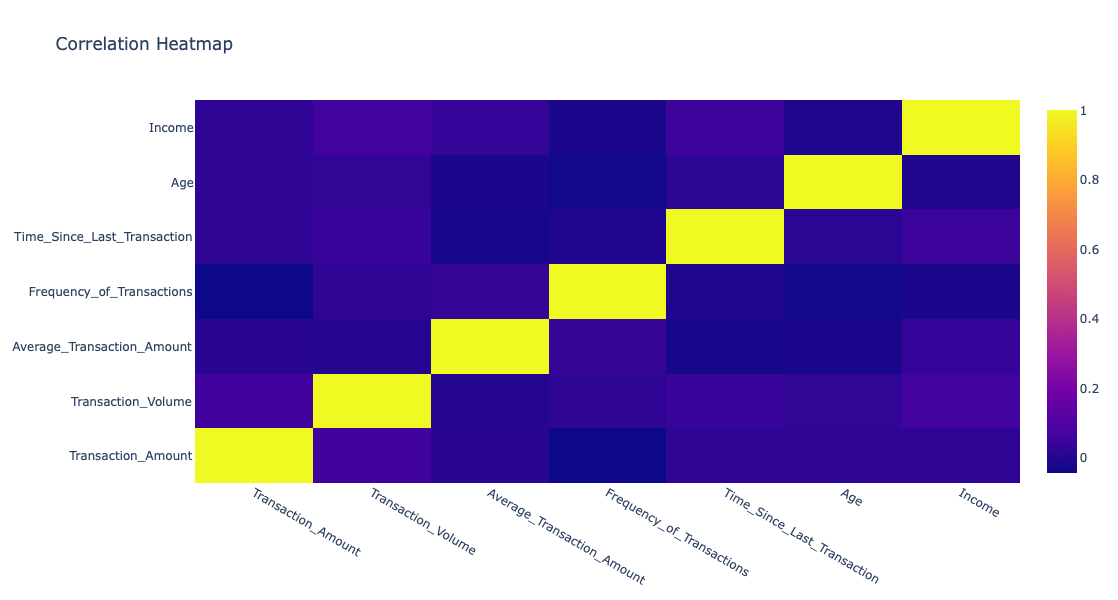

In [10]:
# Heatmap of features
numeric_data = data.select_dtypes(include=['number'])
correlation_matrix = numeric_data.corr()
fig_corr_heatmap = go.Figure(data = go.Heatmap(z = correlation_matrix.values, x = correlation_matrix.columns, y = correlation_matrix.index))
fig_corr_heatmap.update_layout(title = 'Correlation Heatmap', height = 600)
fig_corr_heatmap.show()

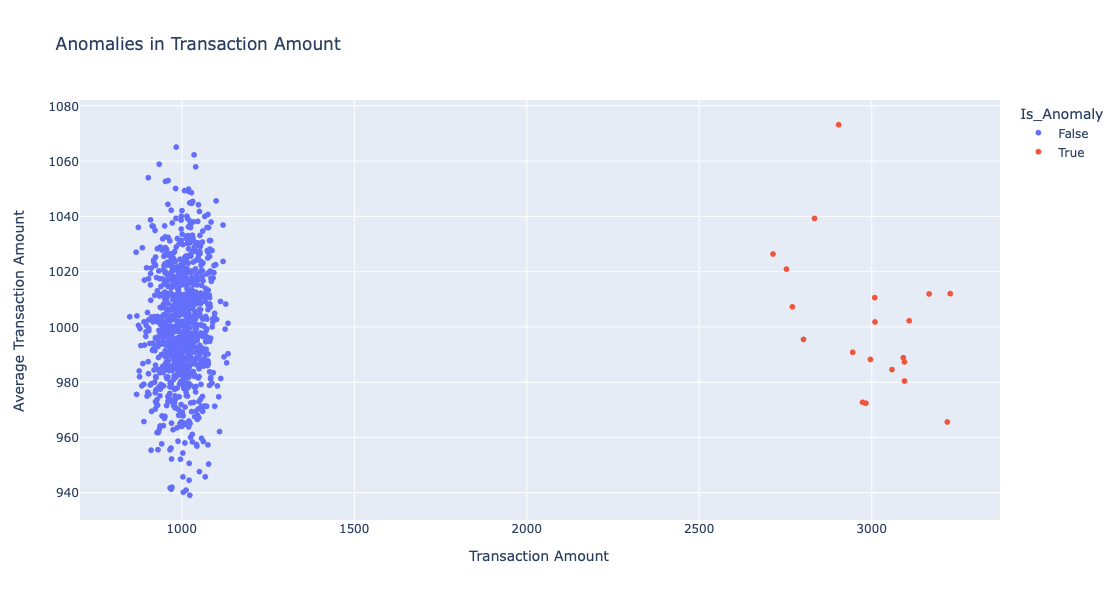

In [11]:
# Calculate mean and standard deviation of Transaction Amount
mean_amount = data['Transaction_Amount'].mean()
std_amount = data['Transaction_Amount'].std()

# Define the anomaly threshold (2 standard deviations from the mean)
anomaly_threshold = mean_amount + 2 * std_amount

# Flag anomalies
data['Is_Anomaly'] = data['Transaction_Amount'] > anomaly_threshold

# Scatter plot of Transaction Amount with anomalies highlighted
anomalies = px.scatter(data, x = 'Transaction_Amount', y = 'Average_Transaction_Amount',color = 'Is_Anomaly', 
                           title = 'Anomalies in Transaction Amount')
anomalies.update_traces(marker = dict(size = 12), selector = dict(mode = 'markers', marker_size = 1))
anomalies.update_layout(height = 600, xaxis_title = 'Transaction Amount', yaxis_title = 'Average Transaction Amount')
anomalies.show()

In [12]:
# Calculate the number of anomalies
num_anomalies = data['Is_Anomaly'].sum()

# Calculate the total number of instances in the dataset
total_instances = data.shape[0]

# Calculate the ratio of anomalies
anomaly_ratio = num_anomalies / total_instances
print(anomaly_ratio)

0.02


In [13]:
# Isolation forest
relevant_features = ['Transaction_Amount', 'Average_Transaction_Amount', 'Frequency_of_Transactions']

# Split data into features (X) and target variable (y)
X = data[relevant_features]
y = data['Is_Anomaly']

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

# Train the Isolation Forest model
model = IsolationForest(contamination = 0.02, random_state = 42)
model.fit(X_train)

/opt/anaconda3/lib/python3.11/site-packages/sklearn/base.py:439: UserWarning:

X does not have valid feature names, but IsolationForest was fitted with feature names



IsolationForest(contamination=0.02, random_state=42)

In [14]:
# Predict anomalies on the test set
y_pred = model.predict(X_test)

# Convert predictions to binary values (0: normal, 1: anomaly)
y_pred_binary = [1 if pred == -1 else 0 for pred in y_pred]

# Evaluate the model's performance
report = classification_report(y_test, y_pred_binary, target_names=['Normal', 'Anomaly'])
print(report)

              precision    recall  f1-score   support

      Normal       1.00      1.00      1.00       196
     Anomaly       1.00      1.00      1.00         4

    accuracy                           1.00       200
   macro avg       1.00      1.00      1.00       200
weighted avg       1.00      1.00      1.00       200



In [15]:
# Relevant features used during training
relevant_features = ['Transaction_Amount', 'Average_Transaction_Amount', 'Frequency_of_Transactions']

# Get user inputs for features
user_inputs = []
for feature in relevant_features:
    user_input = float(input(f"Enter the value for '{feature}': "))
    user_inputs.append(user_input)

# Create a DataFrame from user inputs
user_df = pd.DataFrame([user_inputs], columns=relevant_features)

# Predict anomalies using the model
user_anomaly_pred = model.predict(user_df)

# Convert the prediction to binary value (0: normal, 1: anomaly)
user_anomaly_pred_binary = 1 if user_anomaly_pred == -1 else 0

if user_anomaly_pred_binary == 1:
    print("Anomaly detected: This transaction is flagged as an anomaly.")
else:
    print("No anomaly detected: This transaction is normal.")

Enter the value for 'Transaction_Amount':  10000
Enter the value for 'Average_Transaction_Amount':  900
Enter the value for 'Frequency_of_Transactions':  6


Anomaly detected: This transaction is flagged as an anomaly.


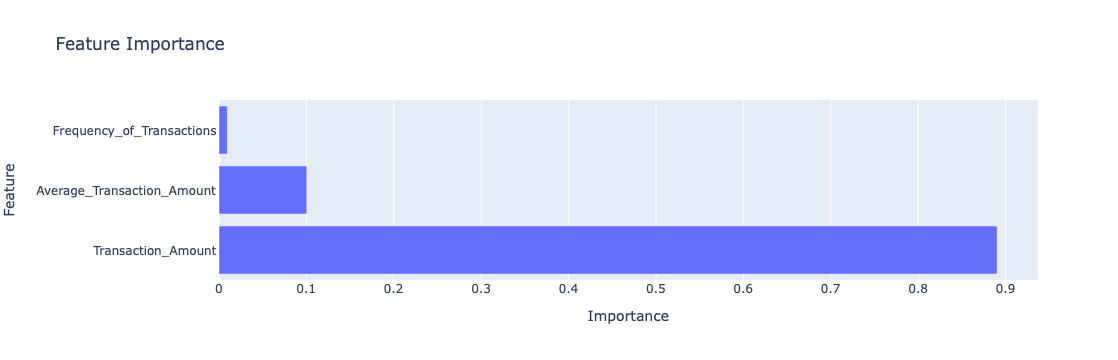

In [16]:
# Assuming 'X' is your feature matrix and 'y' is your target
model = RandomForestClassifier()
model.fit(X_train, y_train)
feature_importance = pd.DataFrame({'Feature': X.columns, 'Importance': model.feature_importances_}).sort_values(by = 'Importance', ascending=False)
fig = px.bar(feature_importance, x = 'Importance', y = 'Feature', title = 'Feature Importance')
fig.show()

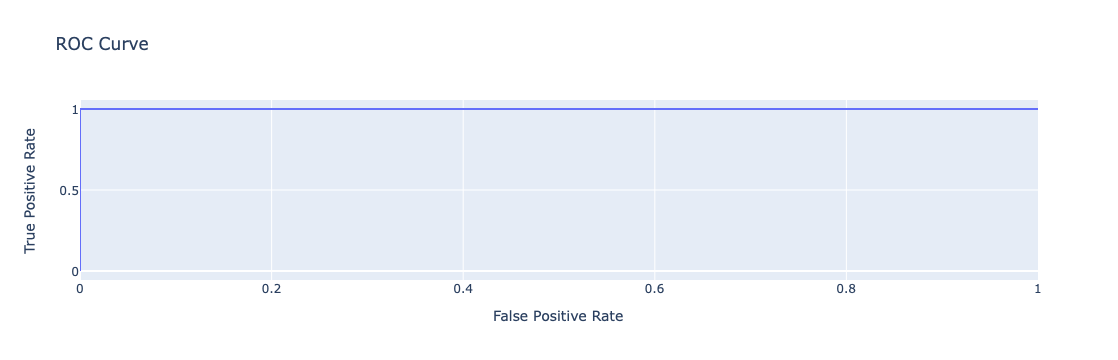

In [17]:
# ROC model
y_pred_prob = model.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
auc = roc_auc_score(y_test, y_pred_prob)

fig = go.Figure()
fig.add_trace(go.Scatter(x = fpr, y = tpr, mode = 'lines', name = f'AUC = {auc:.2f}'))
fig.update_layout(title = 'ROC Curve', xaxis_title = 'False Positive Rate', yaxis_title = 'True Positive Rate')
fig.show()

In [18]:
# Autoencoder 
numeric_data = data.select_dtypes(include=['number'])

scaler = StandardScaler()
numeric_data_scaled = scaler.fit_transform(numeric_data)

# Split data into training and testing sets
from sklearn.model_selection import train_test_split
X_train, X_test = train_test_split(numeric_data_scaled, test_size=0.2, random_state=42)

# Build the autoencoder model
input_dim = X_train.shape[1]
input_layer = Input(shape=(input_dim,))
encoder = Dense(14, activation = "relu")(input_layer)
encoder = Dense(7, activation = "relu")(encoder)
decoder = Dense(14, activation = "relu")(encoder)
decoder = Dense(input_dim, activation = "sigmoid")(decoder)
autoencoder = Model(inputs=input_layer, outputs=decoder)

autoencoder.compile(optimizer = 'adam', loss = 'mean_squared_error')

# Train the autoencoder
history = autoencoder.fit(X_train, X_train, epochs = 50, batch_size = 32, validation_data = (X_test, X_test), verbose = 1)

Epoch 1/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.3045 - val_loss: 1.1581
Epoch 2/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 594us/step - loss: 1.1768 - val_loss: 1.0951
Epoch 3/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 692us/step - loss: 1.0958 - val_loss: 1.0241
Epoch 4/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 649us/step - loss: 1.0161 - val_loss: 0.9623
Epoch 5/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 619us/step - loss: 0.9591 - val_loss: 0.9284
Epoch 6/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 604us/step - loss: 1.0238 - val_loss: 0.9104
Epoch 7/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 600us/step - loss: 1.0053 - val_loss: 0.8970
Epoch 8/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 600us/step - loss: 0.9609 - val_loss: 0.8836
Epoch 9/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 633us/step - loss: 0.8687 - val_loss: 0.8692
Epoch 10/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 637us/step - loss: 0.8921 - val_loss: 0.8547
Epoch 11/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 609us/step - loss: 0.8672 - val_loss: 0.8422
Epoch 12/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 634us/step -

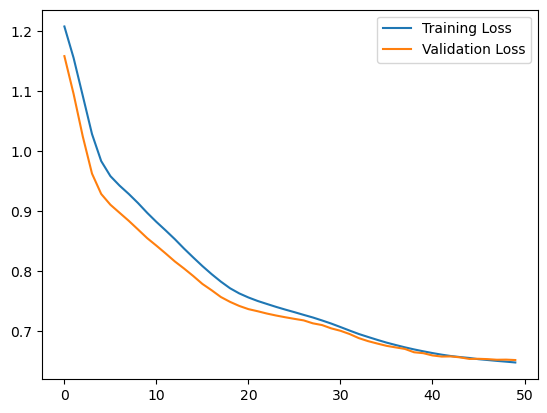

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


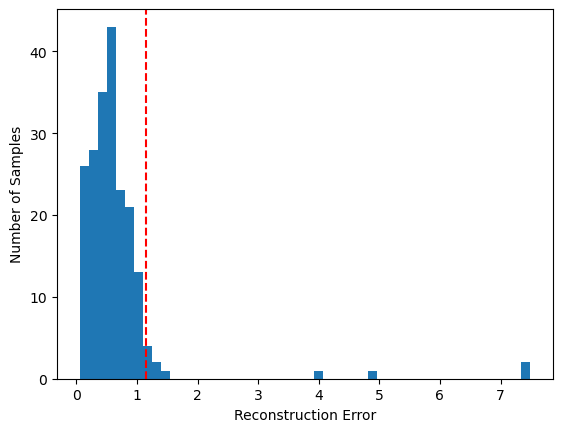

Number of anomalies detected: 10


In [19]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()

# Predict the reconstruction on the test data
X_test_pred = autoencoder.predict(X_test)
mse = np.mean(np.power(X_test - X_test_pred, 2), axis = 1)

# Calculate the reconstruction error threshold
threshold = np.percentile(mse, 95)

# Identify anomalies
anomalies = mse > threshold

# Plot the reconstruction error
plt.hist(mse, bins = 50)
plt.axvline(threshold, color = 'r', linestyle = '--')
plt.xlabel('Reconstruction Error')
plt.ylabel('Number of Samples')
plt.show()

# Print number of anomalies detected
print(f'Number of anomalies detected: {np.sum(anomalies)}')

In [20]:
# Isolation Forest evaluation
roc_score_if = roc_auc_score(y_test, y_pred_binary)
precision_if, recall_if, _ = precision_recall_curve(y_test, y_pred_binary)

print(f"Isolation Forest ROC-AUC: {roc_score_if}")

# Autoencoder evaluation (requires reconstruction error calculation)
reconstruction_error = autoencoder.predict(X_test)
mse = np.mean(np.power(X_test - reconstruction_error, 2), axis=1)
threshold = np.percentile(mse, 95)
y_pred_autoencoder = mse > threshold

roc_score_ae = roc_auc_score(y_test, y_pred_autoencoder)
precision_ae, recall_ae, _ = precision_recall_curve(y_test, y_pred_autoencoder)

print(f"Autoencoder ROC-AUC: {roc_score_ae}")

Isolation Forest ROC-AUC: 1.0
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 309us/step
Autoencoder ROC-AUC: 0.9846938775510203
